In [10]:
import pandas as pd

# Load dataset
data = pd.read_csv('twitter_human_bots_dataset.csv')

# Print dataset information and preview
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    37438 non-null  int64  
 1   created_at                    37438 non-null  object 
 2   default_profile               37438 non-null  bool   
 3   default_profile_image         37438 non-null  bool   
 4   description                   30181 non-null  object 
 5   favourites_count              37438 non-null  int64  
 6   followers_count               37438 non-null  int64  
 7   friends_count                 37438 non-null  int64  
 8   geo_enabled                   37438 non-null  bool   
 9   id                            37438 non-null  int64  
 10  lang                          29481 non-null  object 
 11  location                      37434 non-null  object 
 12  profile_background_image_url  32939 non-null  object 
 13  p

In [11]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd

# Funktion zum Konvertieren des Datums in eine numerische Darstellung (Anzahl Tage seit Account-Erstellung)
def convert_to_account_age_days(date_series):
    current_date = pd.to_datetime('today')  # Aktuelles Datum
    account_creation_date = pd.to_datetime(date_series)  # Konvertiere in Datetime
    return (current_date - account_creation_date).dt.days  # Berechne die Differenz in Tagen

# Erstelle eine neue Spalte 'account_age_days' aus 'created_at'
data['account_age_days'] = convert_to_account_age_days(data['created_at'])

# Fülle fehlende Werte auf
data['description'].fillna('unknown', inplace=True)
data['location'].fillna('unknown', inplace=True)
data['lang'].fillna('unknown', inplace=True)

# Feature Engineering: URLs vorhanden
data['profile_background_image_url'] = data['profile_background_image_url'].notnull().astype(int)  # URL vorhanden = 1, sonst 0

# Feature Engineering: Überprüfe die Beschreibung auf mehrere URLs
def count_urls(text):
    return len(re.findall(r'http[s]?://', str(text)))  # Zählt die Anzahl der URLs in der Beschreibung

data['description_url_count'] = data['description'].apply(count_urls)

# Feature Engineering: Länge der Beschreibung und des Orts
data['description_length'] = data['description'].apply(lambda x: len(str(x)))  # Länge der Beschreibung
data['location_length'] = data['location'].apply(lambda x: len(str(x)))  # Länge der Ortsangabe

# Feature Engineering: Überprüfung des Namens auf ungewöhnliche Muster (viele Zahlen oder Sonderzeichen)
def check_bot_name(name):
    # Überprüfe, ob der Name mehr als 50% Zahlen oder Sonderzeichen enthält
    name = str(name)
    non_alpha_count = len(re.findall(r'[^a-zA-Z]', name))  # Nicht-alphabetische Zeichen zählen
    return int(non_alpha_count / len(name) > 0.5) if len(name) > 0 else 0

data['name_is_suspicious'] = data['screen_name'].apply(check_bot_name)

# Feature Engineering: Freunde-zu-Follower-Verhältnis
data['friends_followers_ratio'] = data['friends_count'] / (data['followers_count'] + 1)  # Vermeide Division durch 0

# Feature Engineering: Durchschnittliche Tweets pro Tag
data['avg_tweets_per_day'] = data['statuses_count'] / (data['account_age_days'] + 1)  # Vermeide Division durch 0

# Entferne Ausreißer in 'followers_count' (beispielsweise oberstes 1%)
upper_limit = data['followers_count'].quantile(0.99)
data = data[data['followers_count'] < upper_limit]

# Wandle boolesche Werte in 1 (True) und 0 (False) um
bool_columns = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']

for col in bool_columns:
    data[col] = data[col].astype(int)

# Konvertiere kategorische Daten in numerische Werte
le = LabelEncoder()
data['account_type'] = le.fit_transform(data['account_type'])  # Zielspalte: 0 = human, 1 = bot
data['lang'] = le.fit_transform(data['lang'])
data['location'] = le.fit_transform(data['location'])

# Entferne die unnötigen Spalten
data = data.drop(['Unnamed: 0', 'id', 'profile_image_url', 'created_at', 'screen_name', 'description'], axis=1)

# Verwende StandardScaler, um die Daten zu standardisieren (Mittelwert 0, Standardabweichung 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop('account_type', axis=1))
y = data['account_type']

# Verwende Lasso zur Feature-Selektion, um irrelevante Features zu entfernen
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)
model = SelectFromModel(lasso, prefit=True)
X_reduced = model.transform(X_scaled)

# Splitte die Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Testprint zur Kontrolle
print("Training data (reduced) shape:", X_train.shape)
print("Test data (reduced) shape:", X_test.shape)

# Zeige ein Beispiel der skalierten und reduzierten Daten
print("Beispiel der reduzierten Daten:")
print(X_train[:5])


Training data (reduced) shape: (29650, 17)
Test data (reduced) shape: (7413, 17)
Beispiel der reduzierten Daten:
[[ 1.16739351 -0.33764007 -0.302634   -0.08532925  1.09561311 -1.23186791
  -1.39317014 -2.69036297 -0.30693271 -0.49021617 -1.90539161 -0.32371342
  -1.12570457  0.14871109 -0.14085207  0.5366672  -0.28511856]
 [-0.85660918  1.65783065 -0.17619107 -0.05071504  1.09561311 -0.63438677
   0.00523658  0.37169706  0.89030611  2.03991639  1.47955106 -0.32371342
   1.71317391  0.48099017 -0.14085207 -0.22004131  0.59159733]
 [-0.85660918 -0.28684605 -0.30159911 -0.0838769   1.09561311  1.68915098
   0.97748852  0.37169706 -0.25341092 -0.49021617 -1.26035883 -0.32371342
  -1.1443814  -0.68198661 -0.14085207 -0.1905357  -0.21422928]
 [ 1.16739351 -0.36095246 -0.30261445 -0.0727826   1.09561311  0.22864154
  -1.6372004   0.37169706 -0.31114549 -0.49021617 -0.17346873 -0.32371342
  -0.30392396  2.14238558 -0.14085207  1.87495203 -0.29390854]
 [ 1.16739351 -0.07779786 -0.30257383 -0.08

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Baue ein vereinfachtes neuronales Netzwerk-Modell mit Batch-Normalisierung
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())  # Batch-Normalisierung
model.add(Dropout(0.5))  # Dropout-Schicht
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Verwende Adam mit einer angepassten Lernrate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Verwende Early Stopping und Reduzierung der Lernrate bei Stagnation
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

# Trainiere das Modell
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, lr_reduction])

# Drucke das Modell-Trainingsergebnis
print("Training abgeschlossen.")


Epoch 1/200
927/927 [==============================] - 6s 6ms/step - loss: 0.6113 - accuracy: 0.7086 - val_loss: 0.5376 - val_accuracy: 0.7603 - lr: 1.0000e-04
Epoch 2/200
927/927 [==============================] - 6s 7ms/step - loss: 0.5550 - accuracy: 0.7461 - val_loss: 0.5177 - val_accuracy: 0.7686 - lr: 1.0000e-04
Epoch 3/200
927/927 [==============================] - 6s 7ms/step - loss: 0.5390 - accuracy: 0.7550 - val_loss: 0.5129 - val_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 4/200
927/927 [==============================] - 6s 6ms/step - loss: 0.5286 - accuracy: 0.7611 - val_loss: 0.5022 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 5/200
927/927 [==============================] - 7s 8ms/step - loss: 0.5191 - accuracy: 0.7645 - val_loss: 0.5001 - val_accuracy: 0.7851 - lr: 1.0000e-04
Epoch 6/200
927/927 [==============================] - 7s 7ms/step - loss: 0.5111 - accuracy: 0.7685 - val_loss: 0.4903 - val_accuracy: 0.7855 - lr: 1.0000e-04
Epoch 7/200
927/927 [===================

232/232 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.8176
Test Loss: 0.4273352324962616
Test Accuracy: 81.76%


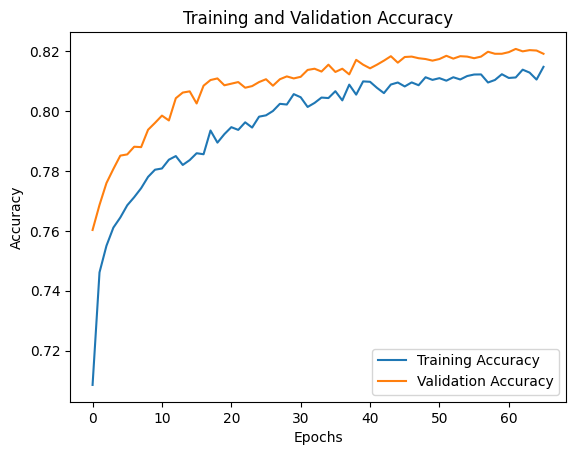

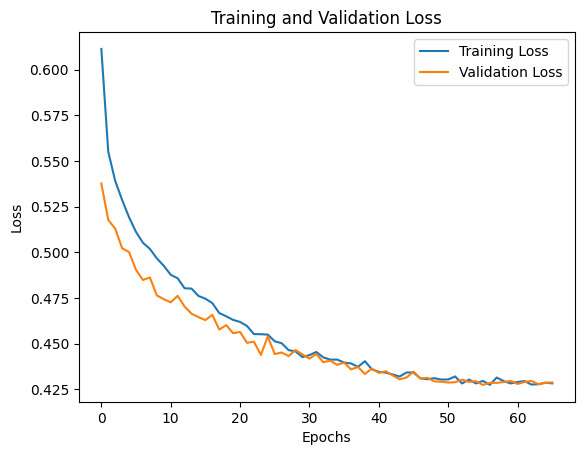

In [14]:
# Evaluierung des Modells auf den Testdaten
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot der Trainings- und Validierungsgenauigkeit
import matplotlib.pyplot as plt

# Genauigkeit während des Trainings
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot des Trainings- und Validierungsverlusts
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


232/232 [==============================] - 0s 1ms/step


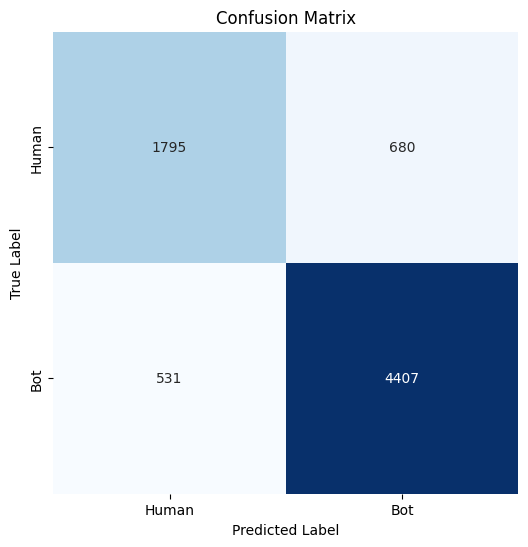

Classification Report:
               precision    recall  f1-score   support

       Human       0.77      0.73      0.75      2475
         Bot       0.87      0.89      0.88      4938

    accuracy                           0.84      7413
   macro avg       0.82      0.81      0.81      7413
weighted avg       0.83      0.84      0.84      7413



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Vorhersagen auf den Testdaten
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Konvertiere Wahrscheinlichkeiten in binäre Vorhersagen

# Erstelle eine Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot der Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Drucke den Klassifikationsbericht (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Human', 'Bot']))


In [8]:
import tf2onnx
import onnx

# Konvertiere das trainierte Keras-Modell in das ONNX-Format
onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)

# Speichere das ONNX-Modell in einer Datei
onnx_model_path = "bot_detector.onnx"
onnx.save_model(onnx_model, onnx_model_path)

print(f"Modell erfolgreich als ONNX-Datei gespeichert: {onnx_model_path}")


Modell erfolgreich als ONNX-Datei gespeichert: bot_detector.onnx
